In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [6]:
# Read in data
df=pd.read_csv("C:\\Users\\jorda\\Documents\\amazonreviewsP25.csv")
print(df.shape)
df = df.head(500)
print(df.shape)

(1000, 10)
(500, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,3001,B0009JI7O8,A38BTTQSSMU4SO,feliciaflan,0,0,5,1342742400,feliciaflan,I am very pleased with this product. I almost ...
1,3002,B0009JI7O8,AI7QVPI5LKFGG,imi36,0,0,5,1340323200,Fortune Cookies,This is the second time I have ordered this pr...
2,3003,B0009JI7O8,AU9Q5W0WD5TO7,XBD1226,0,0,5,1332374400,Very good,Well packed. Few are broken but it is understa...
3,3004,B0009JI7O8,A39ND8C922HWRZ,Jacklyn,0,0,5,1326672000,awsome!!,"Great Product, fast shipment,the food product ..."
4,3005,B0009JI7O8,A2Z7Q8A0MG9VJL,Daisy,0,0,5,1325894400,PERFECT,"I bought these as a gift for my sister, I was ..."


In [10]:
#Data Cleaning

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Downloading required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
#Select & Clean Columns ===
df = df[['Score', 'Summary', 'Text']].copy()
df.dropna(subset=['Text'], inplace=True)

# Combine Summary + Text
df['FullText'] = df['Summary'].astype(str) + " " + df['Text'].astype(str)

#Text Cleaning Function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['FullText'] = df['FullText'].apply(clean_text)

# Remove Stopwords
stop_words = set(stopwords.words('english'))
df['FullText'] = df['FullText'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['FullText'] = df['FullText'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

print("Text cleaning complete.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text cleaning complete.


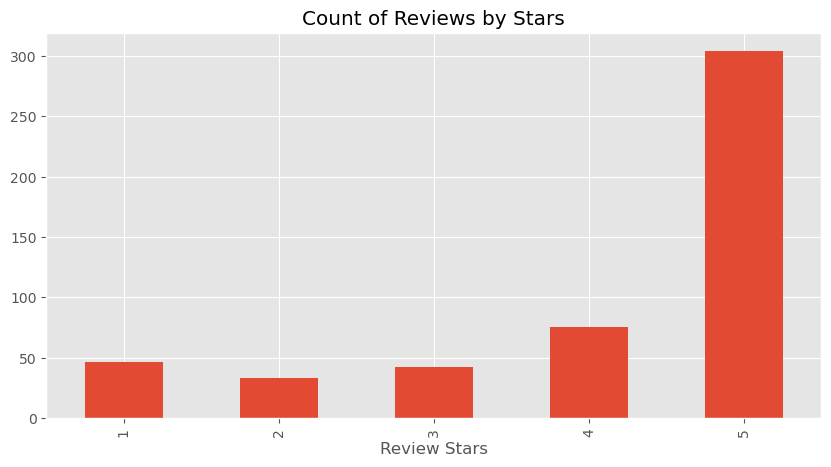

In [11]:
#EDA 
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [12]:
#BASIC NLTK natutal language toolkit
example = df['Text'][50] #WE ARE TAKING THE 50TH COLUMN REVIEW AS AN EXAMPLE HERE
print(example)

My daughter loves these snacks and can't get them in China where she is working now so I ordered them for her. Very satisfied and she was very appreciative.


In [25]:
#MODELS SENTIMENT ANALYSIS #TEXT MINING
#VADER Seniment Scoring #VALENCE AWARE DICTIONARY AND SENTIMNET REASONER
#We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

#This uses a "bag of words" approach:
#Stop words are removed
#each word is scored and combined to a total score.

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [27]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [28]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'compound': 0.893}

In [29]:
# Running the polarity score on the entire dataset
from tqdm import tqdm

tqdm.pandas()

df['sentiment'] = df['Text'].progress_apply(lambda x: sia.polarity_scores(x))

100%|██████████| 500/500 [00:01<00:00, 402.65it/s]


In [31]:
#Sentiment Analysis Using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Create dictionary to store results
res = {}

# Loop through each review
for i, row in df.iterrows():
    text = str(row['FullText'])
    scores = analyzer.polarity_scores(text)
    res[i] = scores  # store using index as key

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

# Merge with your cleaned dataset
vaders = vaders.merge(df, left_on='Id', right_index=True)

# Add a clear sentiment label
vaders['Sentiment_Label'] = vaders['compound'].apply(
    lambda c: 'Positive' if c > 0.05 else ('Negative' if c < -0.05 else 'Neutral')
)


In [32]:
#Now we have sentiment score and metadata
#The result is a single DataFrame containing both the original feedback text and its corresponding sentiment values, ready for analysis or visualization.
vaders.head()

,Id,neg,neu,pos,compound,Score,Summary,Text,FullText,sentiment,Sentiment_Label
0,0,0.000,0.791,0.209,0.4404,5,feliciaflan,I am very pleased with this product. I almost ...,feliciaflan pleased product almost buy looked ...,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",Positive
1,1,0.000,0.636,0.364,0.7906,5,Fortune Cookies,This is the second time I have ordered this pr...,fortune cooky second time ordered product happ...,"{'neg': 0.0, 'neu': 0.765, 'pos': 0.235, 'comp...",Positive
2,2,0.118,0.228,0.655,0.9212,5,Very good,Well packed. Few are broken but it is understa...,good well packed broken understandable cooky t...,"{'neg': 0.052, 'neu': 0.482, 'pos': 0.466, 'co...",Positive
3,3,0.000,0.631,0.369,0.8481,5,awsome!!,"Great Product, fast shipment,the food product ...",awsome great product fast shipmentthe food pro...,"{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'comp...",Positive
4,4,0.000,0.261,0.739,0.9517,5,PERFECT,"I bought these as a gift for my sister, I was ...",perfect bought gift sister excited see arrived...,"{'neg': 0.0, 'neu': 0.557, 'pos': 0.443, 'comp...",Positive


In [43]:
#Topic Extraction using LDA

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

#Loading your dataset

df = pd.read_csv("C:\\Users\\jorda\\Documents\\amazonreviewsP25.csv")

text_col = 'Text'
df = df.dropna(subset=[text_col])

df[text_col] = df[text_col].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

#Converting text into Document-Term Matrix

stop_words = stopwords.words('english')
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=stop_words)
doc_term_matrix = vectorizer.fit_transform(df[text_col])

   
#Training the LDA Model

lda = LatentDirichletAllocation(
    n_components=4,     # Number of topics to extract
    random_state=42,
    learning_method='batch'
)
lda.fit(doc_term_matrix)

#Displayng the Top Words per Topic

feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

print("Top Topics Identified (LDA)")
for idx, topic in enumerate(lda.components_):
    keywords = [feature_names[i] for i in topic.argsort()[-num_top_words:]]
    print(f"Topic {idx + 1}: {', '.join(keywords)}")

#Assignning Dominant Topic to Each Review

topic_values = lda.transform(doc_term_matrix)
df['Dominant_Topic'] = topic_values.argmax(axis=1) + 1  # +1 so topics start from 1

print("Topic extraction complete")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top Topics Identified (LDA)
Topic 1: great, br, cup, flavor, cocoa, like, good, taste, hot, chocolate
Topic 2: amazon, licorice, like, one, br, product, food, price, good, great
Topic 3: good, use, one, water, tried, dont, like, cocoa, br, hot
Topic 4: perfect, product, br, love, good, like, great, bread, tea, coffee
Topic extraction complete


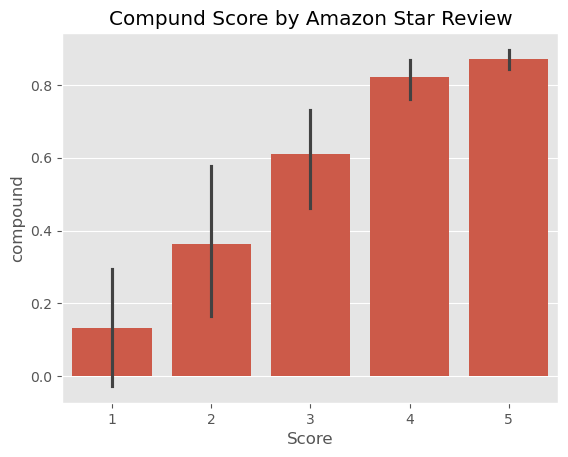

In [33]:
#plotting VADER values
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

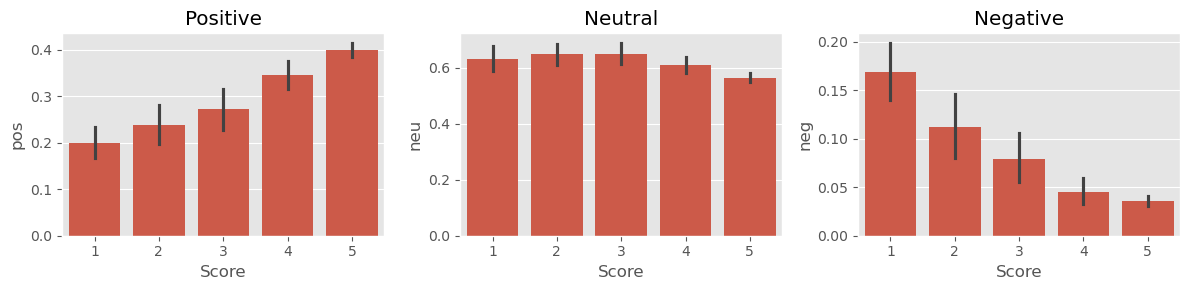

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [37]:
import pickle


with open('vader_lexicon.pkl', 'wb') as f:
    pickle.dump(SentimentIntensityAnalyzer, f)

print("Model saved as sentiment_model.pkl")


Model saved as sentiment_model.pkl


In [40]:
import pandas as pd

df = pd.read_csv("C:\\Users\\jorda\\Documents\\amazonreviewsP25.csv")
print(df.columns)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
